### Import libraries

In [11]:
from pylab import *
import numpy as np
from matplotlib import rc
import os
from scipy.interpolate import interp1d
import pandas as pd  # For CSV export

# Specific libraries
import cosmolib as cs

# Visuals
rc('figure',figsize=(10,5))
rc('font',size=12)
rc('text',usetex=False)

### IMINUIT

In [12]:
# Load redshift data
redshifts = np.loadtxt('data/Data-LightCurves/EI2019-Data-LightCurves-SN-Redshifts.txt')

# Load template lightcurve
t_template, mag_template = np.loadtxt('data/Data-LightCurves/EI2019-Data-LightCurves-SN-SNI-Average_LightCurve.txt').T

# Intrinsic error parameter (magnitude)
sigma_int = 0.12  # Typical intrinsic scatter for SN Ia (can be adjusted)

class SNIaLightCurve:
    def __init__(self, template_data):
        self.template_t = template_data[0]
        self.template_mag = template_data[1]
        self.interpolator = interp1d(
            self.template_t,
            self.template_mag,
            kind='linear',
            fill_value='extrapolate',
            bounds_error=False
        )
        
    def __call__(self, t, pars):
        # pars : [t0, s, mu] where:
        # t0 : time of maximum brightness
        # s : stretch parameter (brighter-slower effect)
        # mu : distance modulus
        t0, s, mu = pars
        
        # Apply time stretch and shift
        t_stretched = (t - t0) / s
        
        # Interpolate template at stretched times using scipy interpolator
        mag_intrinsic = self.interpolator(t_stretched)
        
        # Apply brighter-slower correction: -1.52*(s-1) and add distance modulus
        mag_observed = mag_intrinsic - 1.52*(s-1) + mu
        
        return mag_observed

# Initialize template lightcurve
lc_template = SNIaLightCurve([t_template, mag_template])

# Arbitrary cosmological parameters to initialize mu_guess 
cosmo_pars = {'h': 0.7, 'omega_M_0': 0.5, 'omega_lambda_0': 0.5, 'w0': -1}

# Function to fit individual supernova
def fit_supernova_lightcurve(sn_number, redshift, lc_template, sigma_int, verbose=False):
    """
    Fit a single supernova lightcurve to extract distance modulus
    """
    # Load supernova data
    filename = f'data/Data-LightCurves/EI2019-Data-LightCurves-SN-{sn_number}_lightcurve.txt'
    if not os.path.exists(filename):
        return None
        
    data = np.loadtxt(filename)
    t_obs = data[:, 0]  # observed time
    mag_obs = data[:, 1]  # observed magnitude
    mag_err = data[:, 2]  # magnitude errors
    
    # Add intrinsic error in quadrature
    total_mag_err = np.sqrt(mag_err**2 + sigma_int**2)
    
    # Convert to rest frame time
    t_rest = t_obs / (1 + redshift)
    
    # Initial guess: t0=0, s=1, mu=reasonable distance modulus for the redshift
    # Rough distance modulus estimate from redshift (assuming flat ΛCDM) (Omega_k = 0, according to our arbitrary cosmological parameters)
    mu_guess = cs.musn1a(redshift, cosmo_pars)
    # mu_guess = 35.0

    # Initial guess = [t0, s, mu]
    t0_guess = t_rest[np.argmin(mag_obs)]
    guess = np.array([t0_guess, 1.0, mu_guess])
    
    try:
        # Fit using Minuit with total error (including intrinsic scatter)
        result = cs.do_minuit(t_rest, mag_obs, total_mag_err, guess, 
                             functname=lc_template, verbose=verbose)
        
        fitm, fitted_values, errors, covariance, chi2, ndf = result
        
        return {
            'sn_number': sn_number,
            'redshift': redshift,
            't0': fitted_values[0],
            't0_err': errors[0],
            's': fitted_values[1],
            's_err': errors[1],
            'mu': fitted_values[2],
            'mu_err': errors[2],
            'chi2': chi2,
            'ndf': ndf,
            'chi2_reduced': chi2/ndf if ndf > 0 else np.inf,
            'sigma_int_used': sigma_int
        }
    except Exception as e:
        if verbose:
            print(f"Fitting failed for SN-{sn_number}: {e}")
        return None

# Fit all supernovae
print(f"Fitting individual supernova lightcurves with intrinsic error σ_int = {sigma_int:.3f} mag...")
fitting_results = []

for i in range(len(redshifts)):
    print(f"Fitting SN-{i}...")
    result = fit_supernova_lightcurve(i, redshifts[i], lc_template, sigma_int=sigma_int, verbose=True)
    if result is not None:
        fitting_results.append(result)
        print(f"SN-{i}: μ = {result['mu']:.3f} ± {result['mu_err']:.3f}, s = {result['s']:.3f} ± {result['s_err']:.3f}")
    print()

print(f"Successfully fitted {len(fitting_results)} supernovae")

# Display results
if fitting_results:
    print("\nFitting Results Summary:")
    print("SN\tRedshift\tμ ± σ_μ\t\ts ± σ_s\t\tχ²/ndf")
    print("-" * 70)
    for result in fitting_results:
        print(f"{result['sn_number']}\t{result['redshift']:.3f}\t\t{result['mu']:.3f} ± {result['mu_err']:.3f}\t{result['s']:.3f} ± {result['s_err']:.3f}\t{result['chi2_reduced']:.2f}")

    print(f"\nNote: All fits include intrinsic scatter σ_int = {sigma_int:.3f} mag")



Fitting individual supernova lightcurves with intrinsic error σ_int = 0.120 mag...
Fitting SN-0...
Fitting with Minuit
Chi2 = 10.818567951653234
ndf = 17
Fitted values:
[-0.25736324  1.0398069  43.65314398]
Errors:
[0.73809052 0.08571505 0.15611946]
Covariance:
[[ 0.54477761 -0.04837963 -0.07531404]
 [-0.04837963  0.00734707  0.01301572]
 [-0.07531404  0.01301572  0.02437329]]
SN-0: μ = 43.653 ± 0.156, s = 1.040 ± 0.086

Fitting SN-1...
Fitting with Minuit
Chi2 = 11.654937729241652
ndf = 17
Fitted values:
[ 3.14705141  0.93476756 41.935396  ]
Errors:
[0.21064693 0.02911105 0.08161884]
Covariance:
[[0.04437213 0.00183206 0.00513074]
 [0.00183206 0.00084745 0.00223909]
 [0.00513074 0.00223909 0.00666163]]
SN-1: μ = 41.935 ± 0.082, s = 0.935 ± 0.029

Fitting SN-2...
Fitting with Minuit
Chi2 = 11.010582473465991
ndf = 17
Fitted values:
[-1.88115305  1.10565668 43.73120406]
Errors:
[1.05467438 0.10073104 0.1657745 ]
Covariance:
[[ 1.11233805 -0.09020827 -0.12581558]
 [-0.09020827  0.0101467

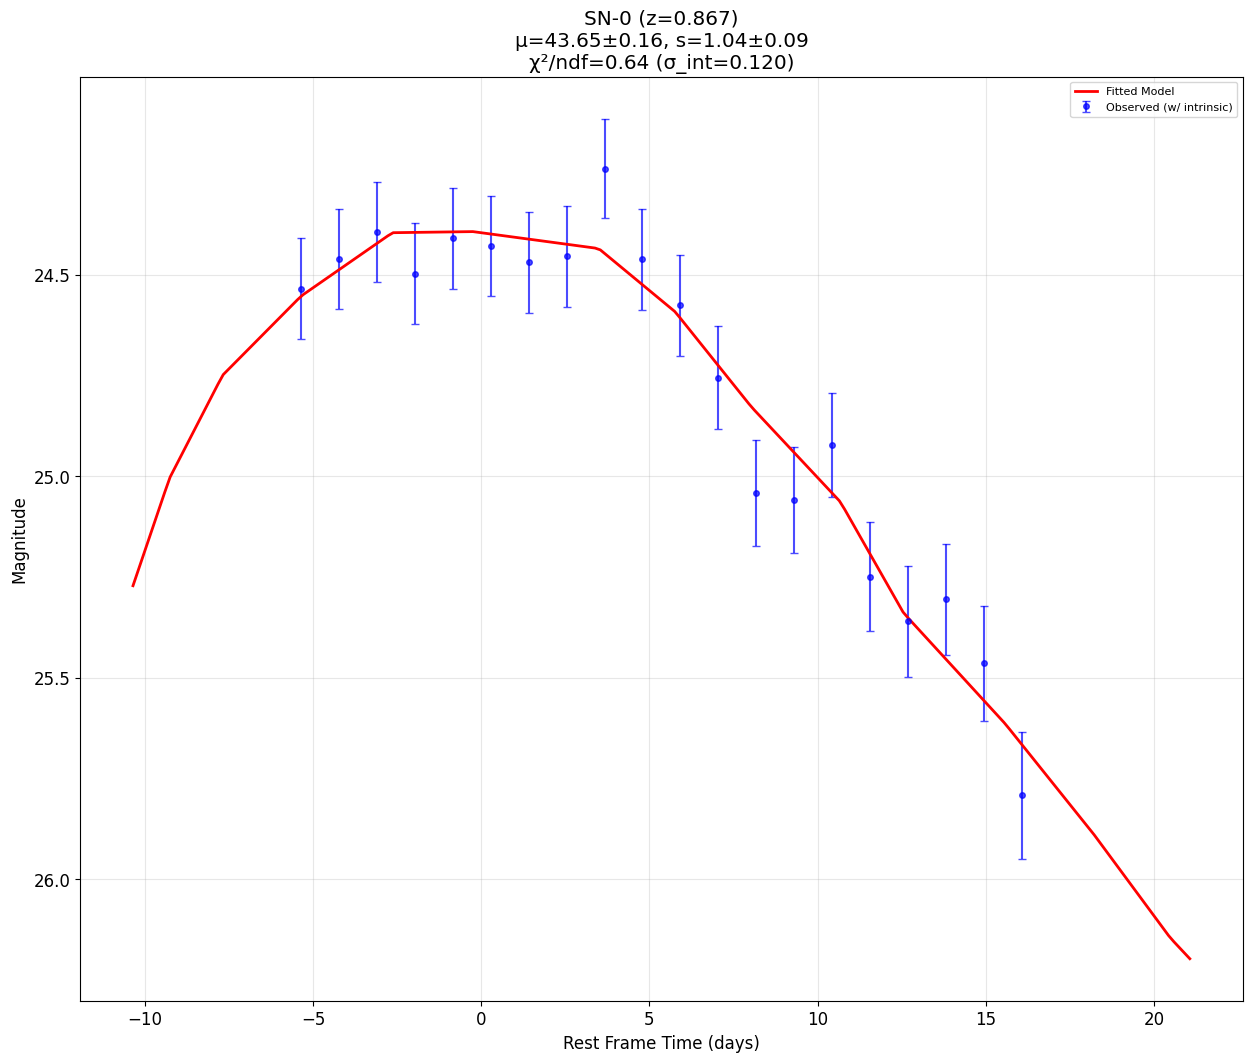

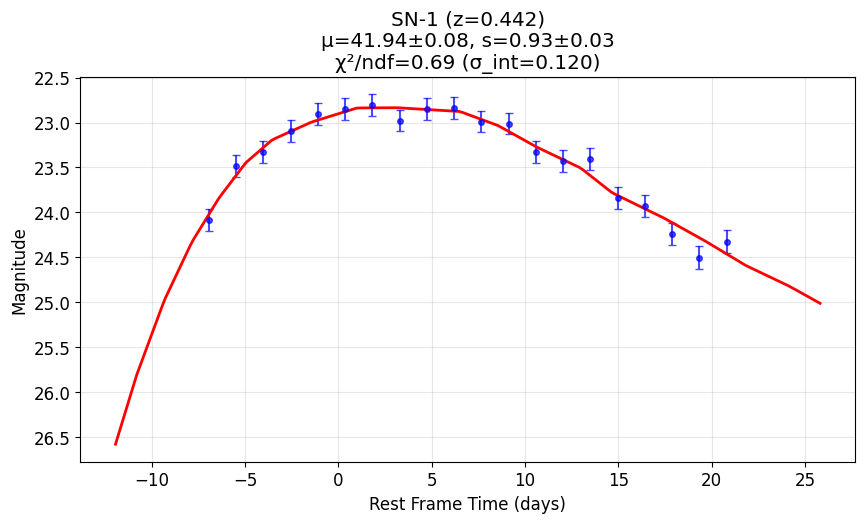


Displayed fitted lightcurves for the first 2 supernovae
Each plot shows:
- Blue points: Observed photometry with total error bars (observational + intrinsic)
- Red line: Best-fit template lightcurve
- Title includes redshift, fitted parameters (μ, s), χ²/ndf, and σ_int=0.120
- Total error = sqrt(observational_error² + 0.120²)


In [13]:
# Plot fitted lightcurves for visualization
if fitting_results:
    # Select a subset of supernovae to plot (first 9 for a 3x3 grid)
    n_plot = min(2, len(fitting_results))
    
    figure(figsize=(15, 12))
    
    for i in range(n_plot):
        result = fitting_results[i]
        sn_number = result['sn_number']
        redshift = result['redshift']
        sigma_int_used = result.get('sigma_int_used', sigma_int)
        
        # Load observed data
        filename = f'data/Data-LightCurves/EI2019-Data-LightCurves-SN-{sn_number}_lightcurve.txt'
        if os.path.exists(filename):
            data = np.loadtxt(filename)
            t_obs = data[:, 0]
            mag_obs = data[:, 1]
            mag_err = data[:, 2]
            
            # Calculate total error (including intrinsic scatter)
            total_mag_err = np.sqrt(mag_err**2 + sigma_int_used**2)
            
            # Convert to rest frame
            t_rest = t_obs / (1 + redshift)
            
            # Generate fitted lightcurve
            t_model = np.linspace(t_rest.min() - 5, t_rest.max() + 5, 200)
            fitted_pars = [result['t0'], result['s'], result['mu']]
            mag_model = lc_template(t_model, fitted_pars)
            
            # Plot in subplot
            
            
            # Plot observed data with total error bars
            errorbar(t_rest, mag_obs, yerr=total_mag_err, fmt='o', 
                    capsize=3, markersize=4, alpha=0.7, label='Observed (w/ intrinsic)', color='blue')
            
            # Plot fitted model
            plot(t_model, mag_model, 'r-', linewidth=2, label='Fitted Model')
            
            # Formatting with chi² value in title
            xlabel('Rest Frame Time (days)')
            ylabel('Magnitude')
            title(f'SN-{sn_number} (z={redshift:.3f})\nμ={result["mu"]:.2f}±{result["mu_err"]:.2f}, s={result["s"]:.2f}±{result["s_err"]:.2f}\nχ²/ndf={result["chi2_reduced"]:.2f} (σ_int={sigma_int_used:.3f})')
            grid(True, alpha=0.3)
            gca().invert_yaxis()  # Invert y-axis for magnitudes (brighter = lower values)
            
            if i == 0:  # Only show legend for first subplot
                legend(loc='upper right', fontsize=8)
            show()
    
    #tight_layout()
    #title('Fitted Supernova Lightcurves (First 9 SNe)', fontsize=16, y=0.98)
    #show()
    
    print(f"\nDisplayed fitted lightcurves for the first {n_plot} supernovae")
    print("Each plot shows:")
    print("- Blue points: Observed photometry with total error bars (observational + intrinsic)")
    print("- Red line: Best-fit template lightcurve")
    print(f"- Title includes redshift, fitted parameters (μ, s), χ²/ndf, and σ_int={sigma_int:.3f}")
    print(f"- Total error = sqrt(observational_error² + {sigma_int:.3f}²)")

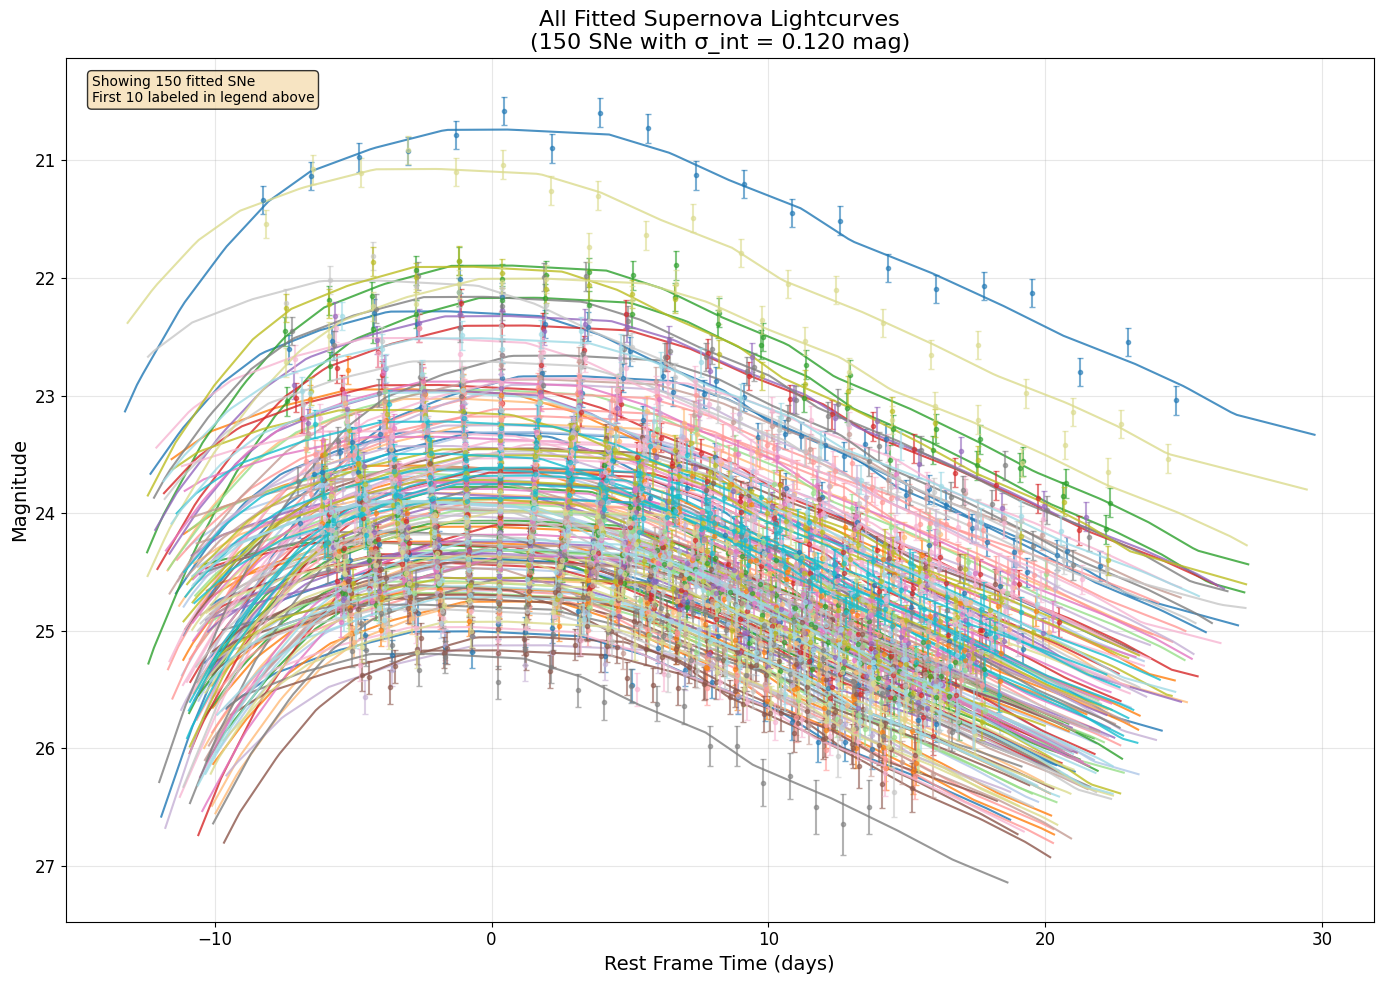


Displayed all 150 fitted lightcurves on the same plot
- Intrinsic scatter σ_int = 0.120 mag included in error bars

Parameter ranges:
- Redshift: 0.213 to 1.263
- Distance modulus μ: 39.94 to 44.59
- Stretch parameter s: 0.827 to 1.301


In [14]:
# Plot all fitted lightcurves on the same plot
if fitting_results:
    figure(figsize=(14, 10))
    
    # Create color map for different supernovae
    colors = plt.cm.tab20(np.linspace(0, 1, len(fitting_results)))
    
    # Plot all lightcurves
    for i, result in enumerate(fitting_results):
        sn_number = result['sn_number']
        redshift = result['redshift']
        sigma_int_used = result.get('sigma_int_used', sigma_int)
        
        # Load observed data
        filename = f'data/Data-LightCurves/EI2019-Data-LightCurves-SN-{sn_number}_lightcurve.txt'
        if os.path.exists(filename):
            data = np.loadtxt(filename)
            t_obs = data[:, 0]
            mag_obs = data[:, 1]
            mag_err = data[:, 2]
            
            # Calculate total error (including intrinsic scatter)
            total_mag_err = np.sqrt(mag_err**2 + sigma_int_used**2)
            
            # Convert to rest frame
            t_rest = t_obs / (1 + redshift)
            
            # Generate fitted lightcurve
            t_model = np.linspace(t_rest.min() - 5, t_rest.max() + 5, 200)
            fitted_pars = [result['t0'], result['s'], result['mu']]
            mag_model = lc_template(t_model, fitted_pars)
            
            # Plot observed data points with smaller markers
            errorbar(t_rest, mag_obs, yerr=total_mag_err, fmt='o', 
                    capsize=2, markersize=3, alpha=0.6, color=colors[i],
                    label=f'SN-{sn_number} (z={redshift:.3f})' if i < 10 else None)
            
            # Plot fitted model with same color
            plot(t_model, mag_model, '-', linewidth=1.5, alpha=0.8, color=colors[i])
    
    # Formatting
    xlabel('Rest Frame Time (days)', fontsize=14)
    ylabel('Magnitude', fontsize=14)
    title(f'All Fitted Supernova Lightcurves\n({len(fitting_results)} SNe with σ_int = {sigma_int:.3f} mag)', fontsize=16)
    grid(True, alpha=0.3)
    gca().invert_yaxis()  # Invert y-axis for magnitudes (brighter = lower values)
    
    # Add legend only for first 10 SNe to avoid clutter
    if len(fitting_results) <= 10:
        legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    else:
        # Add text box with summary info instead of legend
        textstr = f'Showing {len(fitting_results)} fitted SNe\nFirst 10 labeled in legend above'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
        text(0.02, 0.98, textstr, transform=gca().transAxes, fontsize=10,
             verticalalignment='top', bbox=props)
    
    tight_layout()
    show()
    
    print(f"\nDisplayed all {len(fitting_results)} fitted lightcurves on the same plot")
    print(f"- Intrinsic scatter σ_int = {sigma_int:.3f} mag included in error bars")
    
    # Print some statistics about the range of parameters
    mu_values = [r['mu'] for r in fitting_results]
    s_values = [r['s'] for r in fitting_results]
    z_values = [r['redshift'] for r in fitting_results]
    
    print(f"\nParameter ranges:")
    print(f"- Redshift: {min(z_values):.3f} to {max(z_values):.3f}")
    print(f"- Distance modulus μ: {min(mu_values):.2f} to {max(mu_values):.2f}")
    print(f"- Stretch parameter s: {min(s_values):.3f} to {max(s_values):.3f}")

In [15]:
# Export results to CSV file
if fitting_results:
    # Convert results to DataFrame
    df_results = pd.DataFrame(fitting_results)
    
    # Reorder columns for better readability
    column_order = ['sn_number', 'redshift', 'mu', 'mu_err', 's', 's_err', 't0', 't0_err', 
                   'chi2', 'ndf', 'chi2_reduced', 'sigma_int_used']
    df_results = df_results[column_order]
    
    # Add some additional computed columns for analysis
    df_results['mu_significance'] = df_results['mu'] / df_results['mu_err']
    df_results['s_significance'] = abs(df_results['s'] - 1.0) / df_results['s_err']
    
    # Create output filename with timestamp
    from datetime import datetime
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_filename = f'supernova_fitting_results_{timestamp}.csv'
    
    # Save to CSV
    df_results.to_csv(output_filename, index=False, float_format='%.6f')
    
    print(f"\n=== CSV Export Complete ===")
    print(f"Results saved to: {output_filename}")
    print(f"Number of supernovae: {len(df_results)}")
    print(f"Columns exported: {', '.join(df_results.columns)}")
    
    # Display basic statistics
    print(f"\n=== Summary Statistics ===")
    print(f"Distance modulus μ:")
    print(f"  Mean: {df_results['mu'].mean():.3f} ± {df_results['mu'].std():.3f}")
    print(f"  Range: [{df_results['mu'].min():.3f}, {df_results['mu'].max():.3f}]")
    print(f"Stretch parameter s:")
    print(f"  Mean: {df_results['s'].mean():.3f} ± {df_results['s'].std():.3f}")
    print(f"  Range: [{df_results['s'].min():.3f}, {df_results['s'].max():.3f}]")
    print(f"Reduced χ²:")
    print(f"  Mean: {df_results['chi2_reduced'].mean():.2f}")
    print(f"  Good fits (χ²/ndf < 2): {(df_results['chi2_reduced'] < 2).sum()}/{len(df_results)} ({100*(df_results['chi2_reduced'] < 2).mean():.1f}%)")
    
    # Display first few rows for verification
    print(f"\n=== First 5 rows of exported data ===")
    print(df_results.head().to_string(index=False, float_format=lambda x: f'{x:.4f}'))
else:
    print("No fitting results to export!")


=== CSV Export Complete ===
Results saved to: supernova_fitting_results_20250605_130235.csv
Number of supernovae: 150
Columns exported: sn_number, redshift, mu, mu_err, s, s_err, t0, t0_err, chi2, ndf, chi2_reduced, sigma_int_used, mu_significance, s_significance

=== Summary Statistics ===
Distance modulus μ:
  Mean: 43.010 ± 0.840
  Range: [39.944, 44.595]
Stretch parameter s:
  Mean: 1.016 ± 0.089
  Range: [0.827, 1.301]
Reduced χ²:
  Mean: 0.90
  Good fits (χ²/ndf < 2): 150/150 (100.0%)

=== First 5 rows of exported data ===
 sn_number  redshift      mu  mu_err      s  s_err      t0  t0_err    chi2  ndf  chi2_reduced  sigma_int_used  mu_significance  s_significance
         0    0.8670 43.6531  0.1561 1.0398 0.0857 -0.2574  0.7381 10.8186   17        0.6364          0.1200         279.6137          0.4644
         1    0.4420 41.9354  0.0816 0.9348 0.0291  3.1471  0.2106 11.6549   17        0.6856          0.1200         513.7956          2.2408
         2    0.9487 43.7312  0.165

### CSV Export
This section exports the supernova fitting results to a CSV file for further analysis.

# MCMC SN3

Using CSV file: supernova_fitting_results_20250605_130235.csv
Burning


100%|██████████| 500/500 [00:01<00:00, 329.60it/s]


Sampling


100%|██████████| 5000/5000 [00:14<00:00, 344.97it/s]


Autocorrelation time: omega_M = 29.9, omega_lambda = 29.8
Chain length per walker (10000) is 334.6 times autocorrelation time
Acceptance fraction: mean = 0.713, std = 0.007


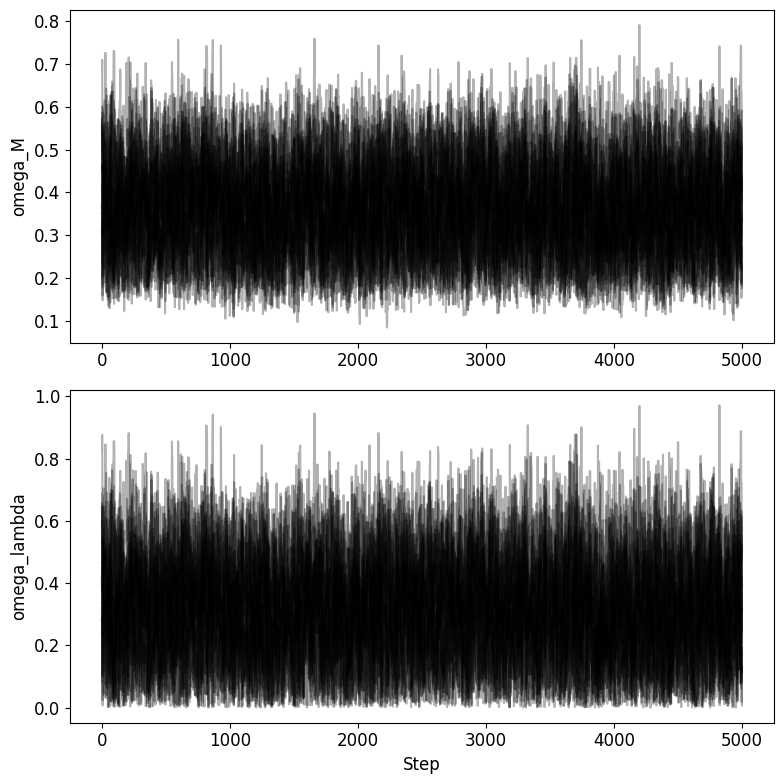

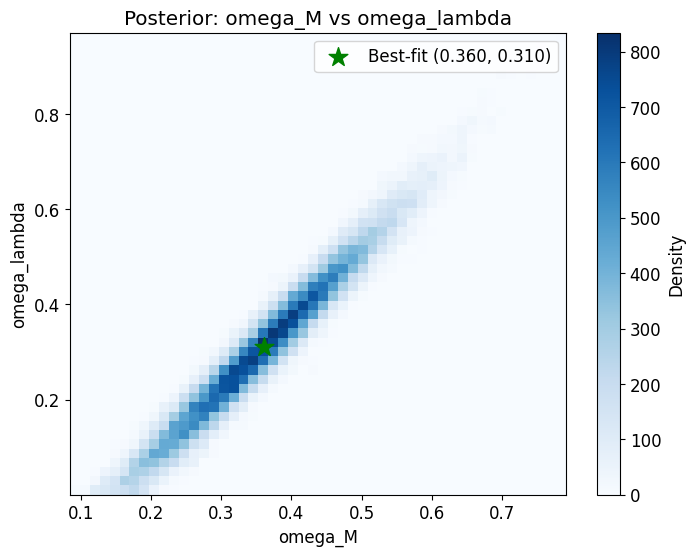

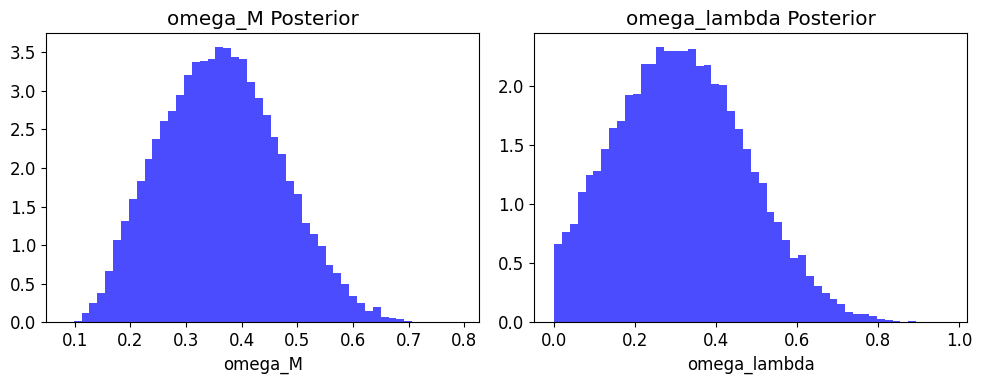

Best-fit omega_M = 0.360 +0.111 -0.109 (68% CI)
Best-fit omega_lambda = 0.310 +0.169 -0.163 (68% CI)
Fixed h = 0.7


In [17]:
import numpy as np
import cosmolib as cs
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import emcee

# Find the latest CSV file
csv_pattern = 'supernova_fitting_results_*.csv'
csv_files = glob.glob(csv_pattern)
if not csv_files:
    raise FileNotFoundError(f"No CSV files found matching pattern: {csv_pattern}")
latest_csv = max(csv_files, key=os.path.getmtime)
print(f"Using CSV file: {latest_csv}")

# Load data
df = pd.read_csv(latest_csv)
z = df['redshift'].values
mu_exp = df['mu'].values
sigma_mu_exp = df['mu_err'].values

# Check for NaN values
if np.any(np.isnan(z)) or np.any(np.isnan(mu_exp)) or np.any(np.isnan(sigma_mu_exp)):
    raise ValueError("Input data contains NaN values")

# Include intrinsic scatter
sigma_int = 0.1
sigma_total = np.sqrt(sigma_mu_exp**2 + sigma_int**2)

# Prediction function
def muPred(z, par):
    return cs.musn1a(z, {'omega_M_0': par[0], 'omega_lambda_0': par[1], 'h': par[2], 'w0': -1})

# Log prior for free parameters
def log_prior_free_pars(free_par):
    omega_m, omega_lambda = free_par
    if 0 <= omega_m <= 1 and 0 <= omega_lambda <= 1:
        return 0  # Uniform prior
    return -np.inf

# Log likelihood
def log_likelihood(par, z, mu_exp, sigma_total):
    mu_model = muPred(z, par)
    if np.any(np.isnan(mu_model)):
        return -np.inf  # Reject invalid models
    chi2 = np.sum((mu_model - mu_exp)**2 / sigma_total**2)
    return -0.5 * chi2

# Log probability
def log_prob_free_pars(free_par, fixed_h, z, mu_exp, sigma_total):
    par = np.array([free_par[0], free_par[1], fixed_h])
    lp = log_prior_free_pars(free_par)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(par, z, mu_exp, sigma_total)

# Fixed h value
fixed_h = 0.7

# Initial guess
guess = np.array([0.3, 0.7])  # omega_M, omega_lambda

# MCMC setup
ndim = 2  # Only omega_M and omega_lambda vary
nwalkers = 20
p0 = [guess + 1e-4 * np.random.randn(ndim) for _ in range(nwalkers)]

# Sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_free_pars, args=(fixed_h, z, mu_exp, sigma_total))

# Burn-in
print("Burning")
pos, _, _ = sampler.run_mcmc(p0, 500, progress=True)
sampler.reset()

# Production run
print("Sampling")
sampler.run_mcmc(pos, 5000, progress=True)

# Convergence diagnostics
try:
    tau = sampler.get_autocorr_time()
    print(f"Autocorrelation time: omega_M = {tau[0]:.1f}, omega_lambda = {tau[1]:.1f}")
    print(f"Chain length per walker (10000) is {10000 / max(tau):.1f} times autocorrelation time")
except emcee.autocorr.AutocorrError:
    print("Warning: Autocorrelation time could not be reliably estimated. Chain may not be converged.")

# Acceptance fraction
acceptance = sampler.acceptance_fraction
print(f"Acceptance fraction: mean = {np.mean(acceptance):.3f}, std = {np.std(acceptance):.3f}")

# Get chain
chain = sampler.get_chain()

# Plot chains
fig, axes = plt.subplots(2, 1, figsize=(8, 8))
axes[0].plot(chain[:, :, 0], 'k', alpha=0.3)
axes[0].set_ylabel('omega_M')
axes[1].plot(chain[:, :, 1], 'k', alpha=0.3)
axes[1].set_ylabel('omega_lambda')
axes[1].set_xlabel('Step')
plt.tight_layout()
plt.show()

# Export chain to CSV
output_chain_filename = 'mcmc_chain.csv'
np.savetxt(output_chain_filename, chain.reshape(-1, ndim), delimiter=',', header='omega_M,omega_lambda', comments='')

# Flatten chain, discard burn-in
flat_chain = chain[1000:, :, :].reshape(-1, ndim)

# Compute best-fit and 68% CI (calculate before plotting)
omegaM_chain = flat_chain[:, 0]
omegaL_chain = flat_chain[:, 1]
omegaM_16, omegaM_50, omegaM_84 = np.percentile(omegaM_chain, [16, 50, 84])
omegaL_16, omegaL_50, omegaL_84 = np.percentile(omegaL_chain, [16, 50, 84])

# 2D histogram
plt.figure(figsize=(8, 6))
plt.hist2d(flat_chain[:, 0], flat_chain[:, 1], bins=50, cmap='Blues')
plt.colorbar(label='Density')
plt.scatter(omegaM_50, omegaL_50, c='g', marker='*', s=200, label=f'Best-fit ({omegaM_50:.3f}, {omegaL_50:.3f})')
plt.xlabel('omega_M')
plt.ylabel('omega_lambda')
plt.title('Posterior: omega_M vs omega_lambda')
plt.legend()
plt.show()

# Marginalized posteriors
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(flat_chain[:, 0], bins=50, density=True, color='blue', alpha=0.7)
axes[0].set_xlabel('omega_M')
axes[0].set_title('omega_M Posterior')
axes[1].hist(flat_chain[:, 1], bins=50, density=True, color='blue', alpha=0.7)
axes[1].set_xlabel('omega_lambda')
axes[1].set_title('omega_lambda Posterior')
plt.tight_layout()
plt.show()

# Results
print(f"Best-fit omega_M = {omegaM_50:.3f} +{(omegaM_84 - omegaM_50):.3f} -{(omegaM_50 - omegaM_16):.3f} (68% CI)")
print(f"Best-fit omega_lambda = {omegaL_50:.3f} +{(omegaL_84 - omegaL_50):.3f} -{(omegaL_50 - omegaL_16):.3f} (68% CI)")
print(f"Fixed h = {fixed_h:.1f}")

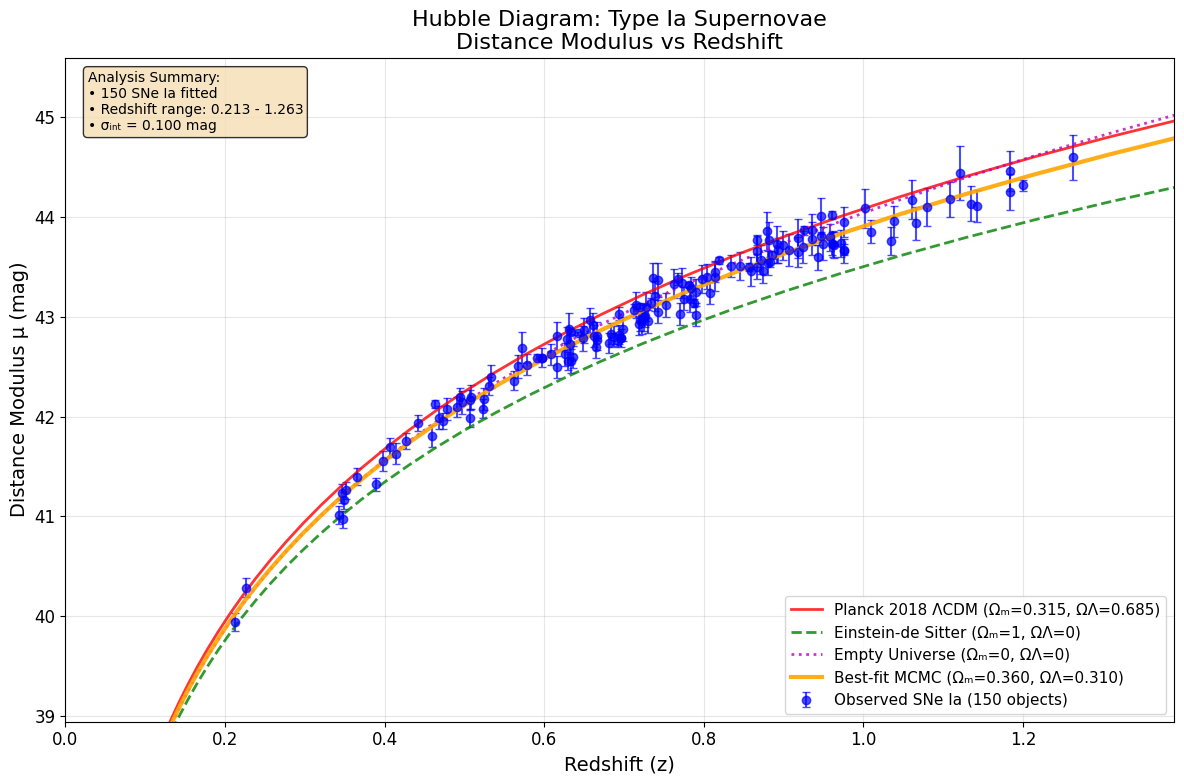


=== Hubble Diagram ====
Plotted 150 supernovae with distance moduli and error bars
Comparison models shown:
- Planck 2018 ΛCDM: Standard cosmological model
- Einstein-de Sitter: Matter-dominated universe
- Empty Universe: Coasting cosmology
- Best-fit MCMC: Your fitted cosmological parameters

The clear deviation from Einstein-de Sitter model demonstrates dark energy!


In [18]:
# Plot Hubble Diagram
if fitting_results:
    plt.figure(figsize=(12, 8))
    
    # Extract data from fitting results
    z_values = [r['redshift'] for r in fitting_results]
    mu_values = [r['mu'] for r in fitting_results]
    mu_errors = [r['mu_err'] for r in fitting_results]
    
    # Plot observed data points with error bars
    plt.errorbar(z_values, mu_values, yerr=mu_errors, fmt='o', 
                capsize=3, markersize=6, alpha=0.7, color='blue',
                label=f'Observed SNe Ia ({len(fitting_results)} objects)')
    
    # Create theoretical curves for comparison
    z_theory = np.logspace(-3, np.log10(max(z_values)*1.2), 100)
    
    # Standard ΛCDM model (Planck 2018 values)
    planck_pars = {'omega_M_0': 0.315, 'omega_lambda_0': 0.685, 'h': 0.674, 'w0': -1}
    mu_planck = cs.musn1a(z_theory, planck_pars)
    plt.plot(z_theory, mu_planck, 'r-', linewidth=2, alpha=0.8, 
             label='Planck 2018 ΛCDM (Ωₘ=0.315, ΩΛ=0.685)')
    
    # Einstein-de Sitter model (Ωₘ=1, ΩΛ=0)
    eds_pars = {'omega_M_0': 1.0, 'omega_lambda_0': 0.0, 'h': 0.7, 'w0': -1}
    mu_eds = cs.musn1a(z_theory, eds_pars)
    plt.plot(z_theory, mu_eds, 'g--', linewidth=2, alpha=0.8,
             label='Einstein-de Sitter (Ωₘ=1, ΩΛ=0)')
    
    # Empty universe model (Ωₘ=0, ΩΛ=0)
    empty_pars = {'omega_M_0': 0.0, 'omega_lambda_0': 0.0, 'h': 0.7, 'w0': -1}
    mu_empty = cs.musn1a(z_theory, empty_pars)
    plt.plot(z_theory, mu_empty, 'm:', linewidth=2, alpha=0.8,
             label='Empty Universe (Ωₘ=0, ΩΛ=0)')
    
    # If MCMC results are available, plot best-fit model
    try:
        if 'omegaM_50' in locals() and 'omegaL_50' in locals():
            best_fit_pars = {'omega_M_0': omegaM_50, 'omega_lambda_0': omegaL_50, 'h': fixed_h, 'w0': -1}
            mu_best_fit = cs.musn1a(z_theory, best_fit_pars)
            plt.plot(z_theory, mu_best_fit, 'orange', linewidth=3, alpha=0.9,
                     label=f'Best-fit MCMC (Ωₘ={omegaM_50:.3f}, ΩΛ={omegaL_50:.3f})')
    except NameError:
        pass
    
    # Formatting
    plt.xlabel('Redshift (z)', fontsize=14)
    plt.ylabel('Distance Modulus μ (mag)', fontsize=14)
    plt.title('Hubble Diagram: Type Ia Supernovae\nDistance Modulus vs Redshift', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11, loc='lower right')
    
    # Set reasonable axis limits
    plt.xlim(0, max(z_values)*1.1)
    plt.ylim(min(mu_values)-1, max(mu_values)+1)
    
    # Add text box with analysis info
    textstr = f'Analysis Summary:\n• {len(fitting_results)} SNe Ia fitted\n• Redshift range: {min(z_values):.3f} - {max(z_values):.3f}\n• σᵢₙₜ = {sigma_int:.3f} mag'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.show()
    
    print("\n=== Hubble Diagram ====")
    print(f"Plotted {len(fitting_results)} supernovae with distance moduli and error bars")
    print("Comparison models shown:")
    print("- Planck 2018 ΛCDM: Standard cosmological model")
    print("- Einstein-de Sitter: Matter-dominated universe")
    print("- Empty Universe: Coasting cosmology")
    if 'omegaM_50' in locals():
        print(f"- Best-fit MCMC: Your fitted cosmological parameters")
    print(f"\nThe clear deviation from Einstein-de Sitter model demonstrates dark energy!")
else:
    print("No supernova data available for Hubble diagram")

# MCMC on SN3 and CMB 3

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emcee
import cosmolib as cs
import glob
import os

import pypico
pico = pypico.load_pico("jcset_py3.dat")

# --- Load Supernovae Data ---
csv_pattern = 'supernova_fitting_results_*.csv'
csv_files = glob.glob(csv_pattern)
if not csv_files:
    raise FileNotFoundError(f"No CSV files found matching pattern: {csv_pattern}")
latest_csv = max(csv_files, key=os.path.getmtime)
print(f"Using CSV file: {latest_csv}")
df = pd.read_csv(latest_csv)
z = df['redshift'].values
mu_exp = df['mu'].values
sigma_mu_exp = df['mu_err'].values
sigma_int = 0.1
sigma_total = np.sqrt(sigma_mu_exp**2 + sigma_int**2)

# --- Load CMB Data ---
ellvalues, dlexp, dlnoise = np.loadtxt('cl_forWP3.txt').T
deltal = 10
fsky = 0.1
var_dl = (2/((2*ellvalues+1)*deltal*fsky))*dlexp**2
errors_bar =  np.sqrt(dlnoise**2 + var_dl)

# --- PICO Setup ---
parpico = pico.example_inputs().copy()
parpico['ombh2'] = 0.02079
parpico['As'] = np.exp(3.094)/1e10
parpico['ns'] = 0.9645
parpico['tau'] = 0.079

def nearest_index(ell, l_data):
    index = []
    for i in range(len(l_data)):
        distances = np.abs(ell - l_data[i])
        index.append(np.argmin(distances))
    return index

def generate_Dl(x, param):
    h, om, ol = param
    if max(abs(h),abs(om),abs(ol))>10:
        return [-1e9 for _ in range(len(x))]
    try:
        inputs = pico.example_inputs()
        inputs['H0'] = 100*h
        inputs['omch2'] = om*h**2-parpico['ombh2']
        inputs['omk'] = 1 - (om+ol)
        data = pico.get(**inputs)
    except Exception:
        return [1e9 for _ in range(len(x))]
    index = nearest_index(data['ell'], x)
    return data['dl_TT'][index]

def chi2_cmb(param):
    h, om, ol = param
    Dl_model = generate_Dl(ellvalues, (h, om, ol))
    Dl_model = np.array(Dl_model)
    if np.any(np.abs(Dl_model) > 1e8):
        return 1e10
    return np.sum((dlexp - Dl_model)**2 / errors_bar**2)

def muPred(z, par):
    return cs.musn1a(z, {'omega_M_0': par[0], 'omega_lambda_0': par[1], 'h': par[2], 'w0': -1})

def chi2_sn(par, z, mu_exp, sigma_total):
    mu_model = muPred(z, par)
    if np.any(np.isnan(mu_model)):
        return 1e10
    return np.sum((mu_model - mu_exp)**2 / sigma_total**2)

# --- Joint log-probability ---
def log_prior(theta):
    omega_m, omega_lambda, h = theta
    if 0 < omega_m < 1 and 0 < omega_lambda < 1 and 0.5 < h < 0.9:
        return 0
    return -np.inf

def log_prob(theta, z, mu_exp, sigma_total):
    omega_m, omega_lambda, h = theta
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    chi2sn = chi2_sn([omega_m, omega_lambda, h], z, mu_exp, sigma_total)
    chi2cmb = chi2_cmb([h, omega_m, omega_lambda])
    return -0.5 * (chi2sn + chi2cmb)

# --- MCMC Setup ---
ndim = 3
nwalkers = 32
fixed_h = 0.7
guess = np.array([0.3, 0.7, fixed_h])
p0 = [guess + 1e-2*np.random.randn(ndim) for _ in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(z, mu_exp, sigma_total))
print("Burn-in...")
pos, _, _ = sampler.run_mcmc(p0, 500, progress=True)
sampler.reset()
print("Sampling...")
sampler.run_mcmc(pos, 2000, progress=True)
chain = sampler.get_chain(flat=True)

# --- Plotting ---
plt.figure(figsize=(8,6))
plt.hexbin(chain[:,0], chain[:,1], gridsize=60, cmap='Blues', mincnt=1)
plt.xlabel(r'$\Omega_m$', fontsize=14)
plt.ylabel(r'$\Omega_\Lambda$', fontsize=14)
plt.title('Joint Posterior: SNe + CMB', fontsize=16)
plt.colorbar(label='Sample Density')
plt.tight_layout()
plt.show()

AttributeError: module 'pypico' has no attribute 'load_pico'